In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
len(os.listdir('/tmp/Datasets/'))

5

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import tensorflow
import glob
import tqdm

In [5]:
from tqdm import tqdm

In [6]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
%matplotlib inline

In [9]:
!qos=$(ls ../tmp/Datasets/train/CANCEROUS/*.jpeg |grep V)

In [10]:
!cp -r ../tmp/Datasets/chest_xray/train/ ./

In [11]:
!ls train

CANCEROUS  NORMAL


In [12]:
train_cancerous = glob.glob('tmp/Datasets/train/CANCEROUS/*.jpeg')
a = len(os.listdir('/tmp/Datasets/train/CANCEROUS'))

In [13]:
train_normal = glob.glob('tmp/Datasets/train/NORMAL/*.jpeg')
b= len(os.listdir('/tmp/Datasets/train/NORMAL'))

In [14]:
print("Total nos. of training images are: {}".format(a+b ))

Total nos. of training images are: 5216


In [15]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [16]:
train_dataset = train_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'training',
                                                  batch_size = 64)

Found 4173 images belonging to 2 classes.


In [17]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1043 images belonging to 2 classes.


In [18]:
train_dataset.class_indices

{'CANCEROUS': 0, 'NORMAL': 1}

In [19]:
len(train_dataset)

66

100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


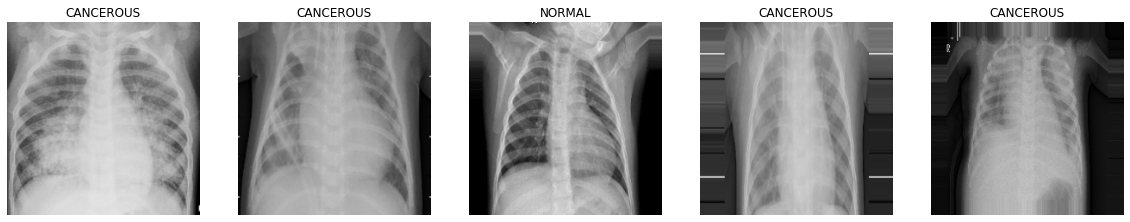

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 0:
        ax[i].set_title('CANCEROUS')
    else :
        ax[i].set_title('NORMAL')

In [23]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [24]:
for layer in base_model.layers:
    layer.trainable=False

In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [28]:
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [29]:
filepath = './lu_prediction.h5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 3,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [30]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.2442 - auc: 0.9618
Epoch 00001: val_auc improved from -inf to 0.99115, saving model to ./lu_prediction.h5
66/66 [==============================] - 167s 2s/step - loss: 0.2442 - auc: 0.9618 - val_loss: 0.1711 - val_auc: 0.9911
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.1378 - auc: 0.9858
Epoch 00002: val_auc improved from 0.99115 to 0.99386, saving model to ./lu_prediction.h5
66/66 [==============================] - 112s 2s/step - loss: 0.1378 - auc: 0.9858 - val_loss: 0.1150 - val_auc: 0.9939
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.1193 - auc: 0.9884
Epoch 00003: val_auc improved from 0.99386 to 0.99637, saving model to ./lu_prediction.h5
66/66 [==============================] - 113s 2s/step - loss: 0.1193 - auc: 0.9884 - val_loss: 0.0853 - val_auc: 0.9964
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.1120 - auc: 0.9892
Epoch 00004: val_

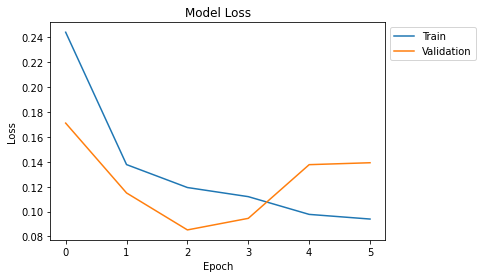

In [31]:
 
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

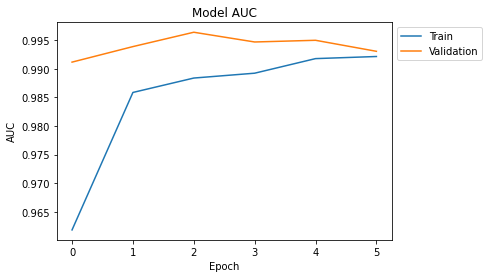

In [32]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

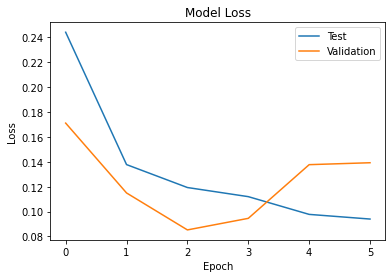

In [33]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [34]:
!cp -r ../tmp/Datasets/chest_xray/test/ ./test

In [35]:
!ls test

CANCEROUS  NORMAL


In [36]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                batch_size = 64)

Found 624 images belonging to 2 classes.


In [37]:
model.evaluate(test_dataset)

10/10 [==============================] - 22s 2s/step - loss: 0.2367 - auc: 0.9729


[0.23672321438789368, 0.9728905558586121]

In [38]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.models import load_model
from keras.preprocessing import image

The X-Ray is NORMAL


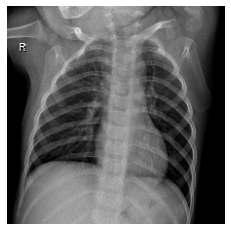

In [40]:
img = image.load_img('/tmp/Datasets/val/NORMAL/NORMAL2-IM-1442-0001.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray is NORMAL")
else:
    print("The X-RAY indicates the presence of CANCER")

The X-RAY indicates the presence of CANCER


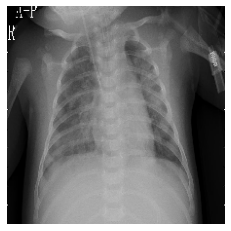

In [66]:
img = image.load_img('/tmp/Datasets/val/CANCEROUS/person1946_bacteria_4875.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray is NORMAL")
else:
    print("The X-RAY indicates the presence of CANCER")

In [42]:
model.save('lu_prediction.h5')

In [60]:
from tensorflow.keras.models import load_model
lo_model=load_model('lu_prediction.h5')

In [61]:
lo_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [62]:
lo_model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

The X-Ray is NORMAL


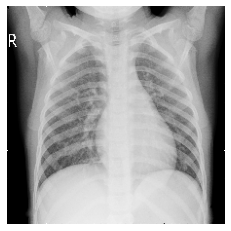

In [63]:
img = image.load_img('/tmp/Datasets/val/NORMAL/NORMAL2-IM-1431-0001.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray is NORMAL")
else:
    print("The X-RAY indicates the presence of CANCER")

The X-RAY indicates the presence of CANCER


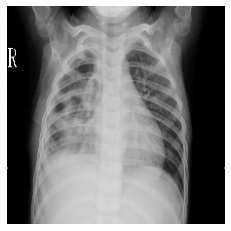

In [68]:
img = image.load_img('/tmp/Datasets/val/CANCEROUS/person1954_bacteria_4886.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray is NORMAL")
else:
    print("The X-RAY indicates the presence of CANCER")